In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [56]:
# Variables
# Aircraft numbers
B757_M200_n = 47
A340_M200_n = 15
A340_M300_n = 24

# Replacement Cost
B757_M200_rc = 56_400_000
A340_M200_rc = 78_900_000
A340_M300_rc = 88_500_000

# Flights per day
B757_M200_fpd = 6
A340_M200_fpd = 2.25
A340_M300_fpd = 2

# Flights per year
Yearly_Flying_Days = 342
B757_M200_fpy = B757_M200_fpd * Yearly_Flying_Days 
A340_M200_fpy = A340_M200_fpd * Yearly_Flying_Days
A340_M300_fpy = A340_M300_fpd * Yearly_Flying_Days

# Probability of Crash is 1 in 5 mil flights
p_crash = 1 / 5_000_000

# Yearly probability of each plane crashing
B757_M200_ypcrash = B757_M200_fpy * p_crash
A340_M200_ypcrash = A340_M200_fpy * p_crash
A340_M300_ypcrash = A340_M300_fpy * p_crash

# Total fleet replacement cost
TFRC = (B757_M200_n * B757_M200_rc) + (A340_M200_n * A340_M200_rc) + (A340_M300_n * A340_M300_rc)
print(f"Total fleet replacement cost: ${TFRC:,}")

print([B757_M200_fpy,A340_M200_fpy,A340_M300_fpy])

Total fleet replacement cost: $5,958,300,000
[2052, 769.5, 684]


# Simulation

In [57]:
# Simulations
N = 1_000_000
n = 5

# Simulate Incidental Damages (varies between $1 and $5 million per year)
Inci_Damages = pd.DataFrame(np.random.uniform(1_000_000, 5_000_000, (N, n)))
#display(Inci_Damages)

# Simluate Crashes for each plane
# Generate uniform random numbers between 0 and 1
Crash_Sim_A = pd.DataFrame(np.random.uniform(0, 1, (N, n)))
Crash_Sim_B = pd.DataFrame(np.random.uniform(0, 1, (N, n)))
Crash_Sim_C = pd.DataFrame(np.random.uniform(0, 1, (N, n)))

# If the number is less than the probability of this type of plane crashing this year then it's a crash. 
Crashes_A = Crash_Sim_A.apply(lambda row: row <= B757_M200_ypcrash)
Crashes_B = Crash_Sim_B.apply(lambda row: row <= A340_M200_ypcrash)
Crashes_C = Crash_Sim_C.apply(lambda row: row <= A340_M300_ypcrash)
sum(Crashes_A)



10

# RCNC1

In [58]:
# Insurance costs
# Annual fee paid at beginning of year
Annual_Fee = TFRC * 0.0045
print(f"Annual Fee: ${Annual_Fee:,.2f}")

# 10% deductible of aircraft loss
Cost_Crashes_A = Crashes_A * B757_M200_rc * 0.1
Cost_Crashes_B = Crashes_B * A340_M200_rc * 0.1
Cost_Crashes_C = Crashes_C * A340_M300_rc * 0.1

# Combining crash simulation costs for each plane type
Tot_Cost_Crashes = Cost_Crashes_A + Cost_Crashes_B + Cost_Crashes_C

# Amount covered by RCNC
Covered_A = Crashes_A * B757_M200_rc * 0.9
Covered_B = Crashes_B * A340_M200_rc * 0.9
Covered_C = Crashes_C * A340_M300_rc * 0.9
Total_Covered = Covered_A + Covered_B + Covered_C + Inci_Damages #RCNC covers all of the 1-5 mil of incidental damages

# Calculate rebate, when RCNC has profits, return 20% 
Rebate = pd.DataFrame(np.where(Total_Covered < Annual_Fee, 0.2 * (Annual_Fee - Total_Covered), 0))

Final_Cost = Tot_Cost_Crashes + Annual_Fee - Rebate


Annual Fee: $26,812,350.00


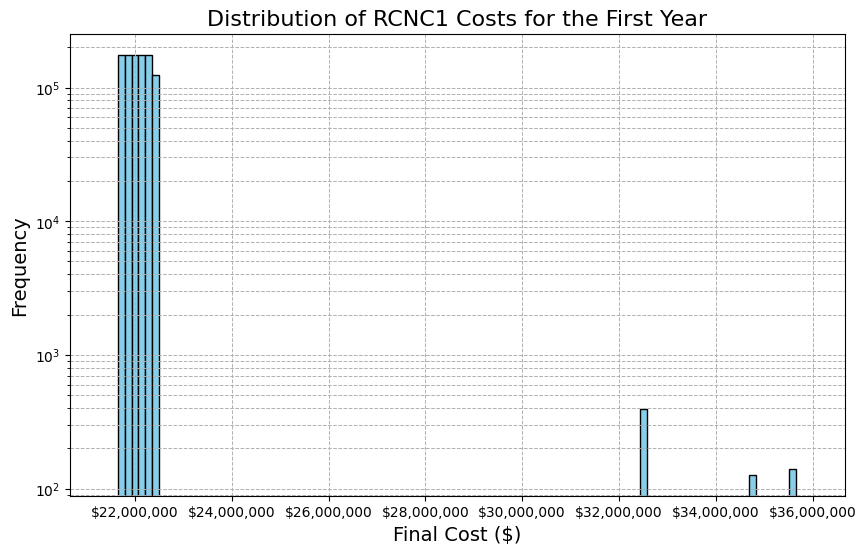

In [59]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the first year's final cost with more bins and restricted x-axis
plt.hist(Final_Cost.iloc[:, 0], bins=100, color='skyblue', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of RCNC1 Costs for the First Year', fontsize=16)
plt.xlabel('Final Cost ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([Final_Cost.iloc[:, 0].min() - 1e6, Final_Cost.iloc[:, 0].max() + 1e6])

# Optionally, use log scale for the y-axis if you want to highlight the long tail
ax.set_yscale('log')

# Show the plot
plt.show()

In [60]:
#Probability of losses exceeding $37mil (10% margin of safety)
prob_37 = np.mean(Final_Cost.iloc[:, 0] > 37_000_000)

#Probability of losses exceeding $41mil
prob_41 = np.mean(Final_Cost.iloc[:, 0] > 41_000_000)

Avg_yr1_cost = np.mean(Final_Cost.iloc[:, 0])
STD_yr1_cost = np.std(Final_Cost.iloc[:, 0])

Low_range = np.min(Final_Cost.iloc[:, 0])
Upper_range = np.max(Final_Cost.iloc[:, 0])

print(f"Probability of losses exceeding $37mil: {prob_37:.4f}\nAverage Cost: ${Avg_yr1_cost:,.2f}\nStandard Deviation: ${STD_yr1_cost:,.2f}")

Probability of losses exceeding $37mil: 0.0000
Average Cost: $22,057,136.86
Standard Deviation: $376,753.15


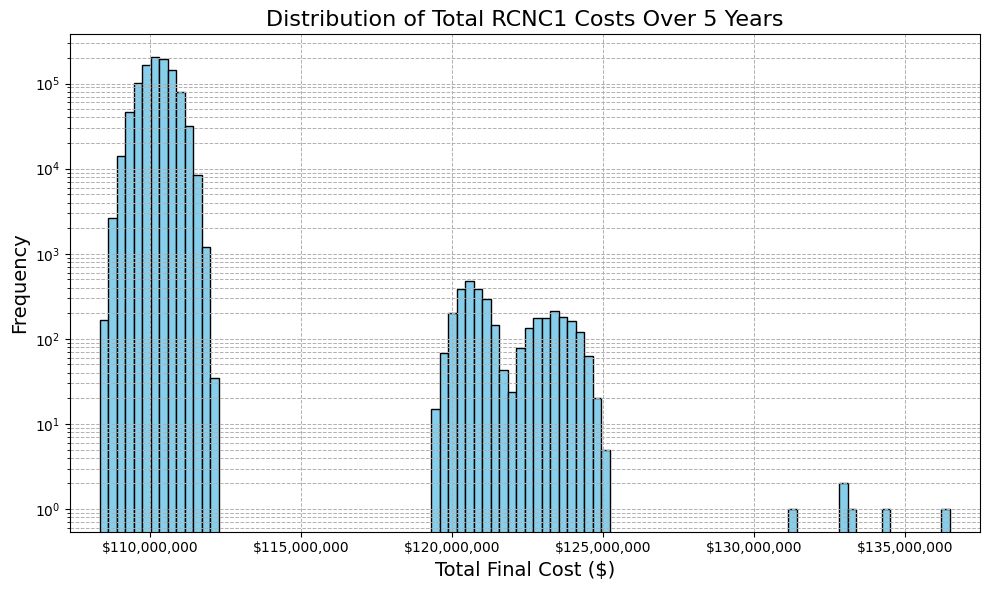

In [61]:
# Calculate the five-year cost
five_year_cost = Final_Cost.sum(axis=1)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the five-year final cost with more bins and restricted x-axis
plt.hist(five_year_cost, bins=100, color='skyblue', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of Total RCNC1 Costs Over 5 Years', fontsize=16)
plt.xlabel('Total Final Cost ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([five_year_cost.min() - 1e6, five_year_cost.max() + 1e6])

# Optionally, use log scale for the y-axis if necessary to highlight the long tail
ax.set_yscale('log')

# Tighten the layout to reduce excess margins
plt.tight_layout()

# Show the plot
plt.show()

In [62]:
Five_Year_Mean = np.mean(five_year_cost)
Five_Year_STD = np.std(five_year_cost)

Low_range_5yr = np.min(five_year_cost)
Upper_range_5yr = np.max(five_year_cost)

print(f"5 year average cost: ${Five_Year_Mean:,.2f}\nWith a standard deviation of ${Five_Year_STD:,.2f}")

5 year average cost: $110,287,991.95
With a standard deviation of $847,875.26


# RCNC2

In [63]:
# Fixed premium per year
Fixed_Premium = TFRC * 0.001
print(f"Fixed Premium: ${Fixed_Premium:,.2f}")

# Variable premium calculation
Variable_Premium_A = Crashes_A * B757_M200_rc * 0.90
Variable_Premium_B = Crashes_B * A340_M200_rc * 0.90
Variable_Premium_C = Crashes_C * A340_M300_rc * 0.90

# Combining variable premiums for each plane type
Total_Variable_Premium = Variable_Premium_A + Variable_Premium_B + Variable_Premium_C + Inci_Damages

# 1% of insured value of the fleet
Premium_option_2 = TFRC * 0.01

# Limit the variable premium to 1% of the fleet value
#Total_Variable_Premium = Total_Variable_Premium.apply(lambda row: np.minimum(row, 0.01 * TFRC), axis=1)
Total_Variable_Premium = pd.DataFrame(np.where(Total_Variable_Premium < Premium_option_2, Total_Variable_Premium, Premium_option_2))

# Calculate the total premium (fixed + variable)
Total_Premium = Fixed_Premium + Total_Variable_Premium

Fixed Premium: $5,958,300.00


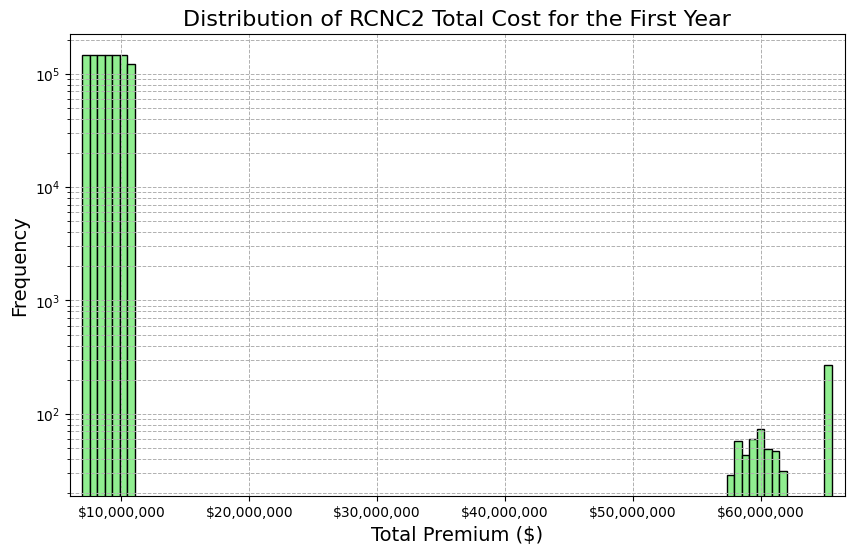

In [64]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the first year's total premium with more bins and restricted x-axis
plt.hist(Total_Premium.iloc[:, 0], bins=100, color='lightgreen', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of RCNC2 Total Cost for the First Year', fontsize=16)
plt.xlabel('Total Premium ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([Total_Premium.iloc[:, 0].min() - 1e6, Total_Premium.iloc[:, 0].max() + 1e6])

# Optionally, use log scale for the y-axis if necessary to highlight the long tail
ax.set_yscale('log')

# Show the plot
plt.show()

In [65]:
# Calculate the probability of exceeding $37 million in the first year
prob_37_RCN2 = np.mean(Total_Premium.iloc[:, 0] > 37_000_000)

# Calculate the probability of exceeding $41 million in the first year
prob_41_RCN2 = np.mean(Total_Premium.iloc[:, 0] > 41_000_000)

# Calculate the average and standard deviation for the first year
Avg_yr1_cost_RCN2 = np.mean(Total_Premium.iloc[:, 0])
STD_yr1_cost_RCN2 = np.std(Total_Premium.iloc[:, 0])

# Range
low_range_RCNC2 = np.min(Total_Premium.iloc[:, 0])
upper_range_RCNC2 = np.max(Total_Premium.iloc[:, 0])

print(f"RCNC2 Probability of losses exceeding $37mil: {prob_37_RCN2:.4f}")
print(f"RCNC2 Average Cost (Year 1): ${Avg_yr1_cost_RCN2:,.2f}")
print(f"RCNC2 Standard Deviation (Year 1): ${STD_yr1_cost_RCN2:,.2f}")


RCNC2 Probability of losses exceeding $37mil: 0.0007
RCNC2 Average Cost (Year 1): $8,991,612.98
RCNC2 Standard Deviation (Year 1): $1,787,197.02


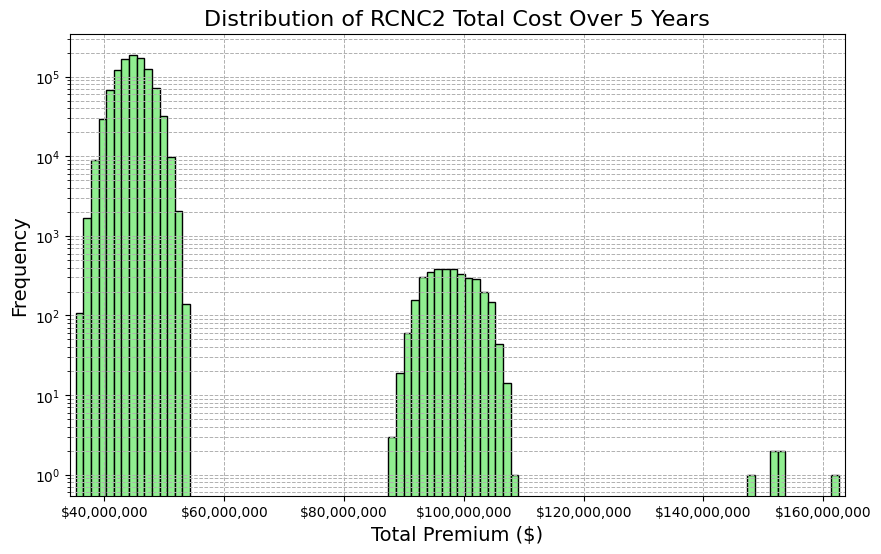

In [66]:
# Calculate the five-year total cost for RCNC2
five_year_cost_RCN2 = Total_Premium.sum(axis=1)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the five-year total premium with more bins and restricted x-axis
plt.hist(five_year_cost_RCN2, bins=100, color='lightgreen', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of RCNC2 Total Cost Over 5 Years', fontsize=16)
plt.xlabel('Total Premium ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([five_year_cost_RCN2.min() - 1e6, five_year_cost_RCN2.max() + 1e6])

# Optionally, use log scale for the y-axis if necessary to highlight the long tail
ax.set_yscale('log')

# Show the plot
plt.show()

In [67]:
# Calculate the 5-year average and standard deviation for RCNC2
Five_Year_Mean_RCN2 = np.mean(five_year_cost_RCN2)
Five_Year_STD_RCN2 = np.std(five_year_cost_RCN2)

# Range
lr_5y_RCNC2 = np.min(five_year_cost_RCN2)
ur_5y_RCNC2 = np.max(five_year_cost_RCN2)

print(f"RCNC2 5-year average cost: ${Five_Year_Mean_RCN2:,.2f}")
print(f"RCNC2 Standard Deviation (5 years): ${Five_Year_STD_RCN2:,.2f}")


RCNC2 5-year average cost: $44,969,661.07
RCNC2 Standard Deviation (5 years): $4,026,282.44


## CTC

In [68]:
# Fixed premium per year
Fixed_Premium = 13_000_000

# Total cost of crashes per year
Cost_Crashes_A = Crashes_A * B757_M200_rc
Cost_Crashes_B = Crashes_B * A340_M200_rc 
Cost_Crashes_C = Crashes_C * A340_M300_rc 
total_crashes = Cost_Crashes_A + Cost_Crashes_B + Cost_Crashes_C + Inci_Damages

Final_Cost_CTC = pd.DataFrame(np.where(total_crashes < 80_000_000, (total_crashes * 0.1)+Fixed_Premium, (80_000_000*0.1) + (total_crashes - 80_000_000)+Fixed_Premium))


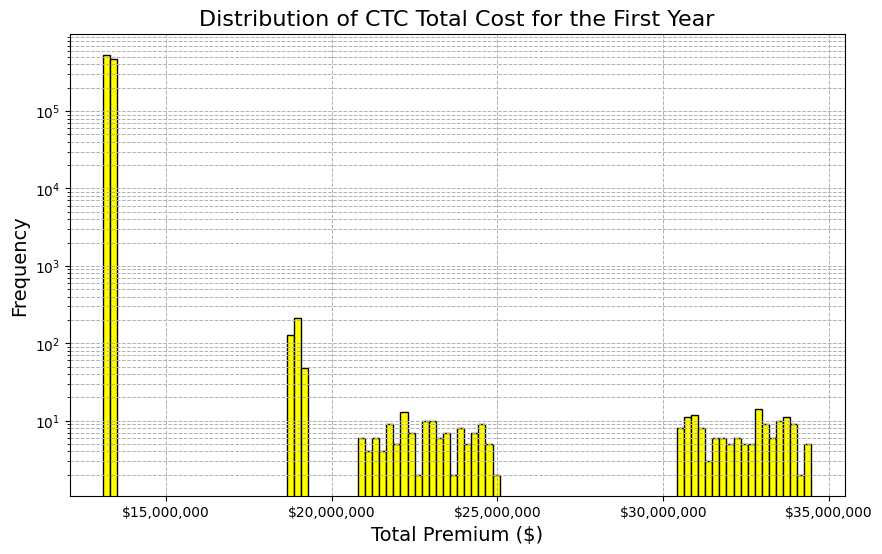

In [69]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the first year's total premium with more bins and restricted x-axis
plt.hist(Final_Cost_CTC.iloc[:, 0], bins=100, color='yellow', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of CTC Total Cost for the First Year', fontsize=16)
plt.xlabel('Total Premium ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([Final_Cost_CTC.iloc[:, 0].min() - 1e6, Final_Cost_CTC.iloc[:, 0].max() + 1e6])

# Optionally, use log scale for the y-axis if necessary to highlight the long tail
ax.set_yscale('log')

# Show the plot
plt.show()

In [70]:
# Calculate the probability of exceeding $37 million in the first year
prob_37_CTC = np.mean(Final_Cost_CTC.iloc[:, 0] > 37_000_000)

# Calculate the probability of exceeding $41 million in the first year
prob_41_CTC = np.mean(Final_Cost_CTC.iloc[:, 0] > 41_000_000)

# Calculate the average and standard deviation for the first year
Avg_yr1_cost_CTC = np.mean(Final_Cost_CTC.iloc[:, 0])
STD_yr1_cost_CTC = np.std(Final_Cost_CTC.iloc[:, 0])

# Range
lr_CTC= np.min(Final_Cost_CTC.iloc[:, 0])
ur_CTC = np.max(Final_Cost_CTC.iloc[:, 0])

print(f"CTC Probability of losses exceeding $37mil: {prob_37_CTC:.4f}")
print(f"CTC Average Cost (Year 1): ${Avg_yr1_cost_CTC:,.2f}")
print(f"CTC Standard Deviation (Year 1): ${STD_yr1_cost_CTC:,.2f}")

CTC Probability of losses exceeding $37mil: 0.0000
CTC Average Cost (Year 1): $13,305,942.75
CTC Standard Deviation (Year 1): $298,422.54


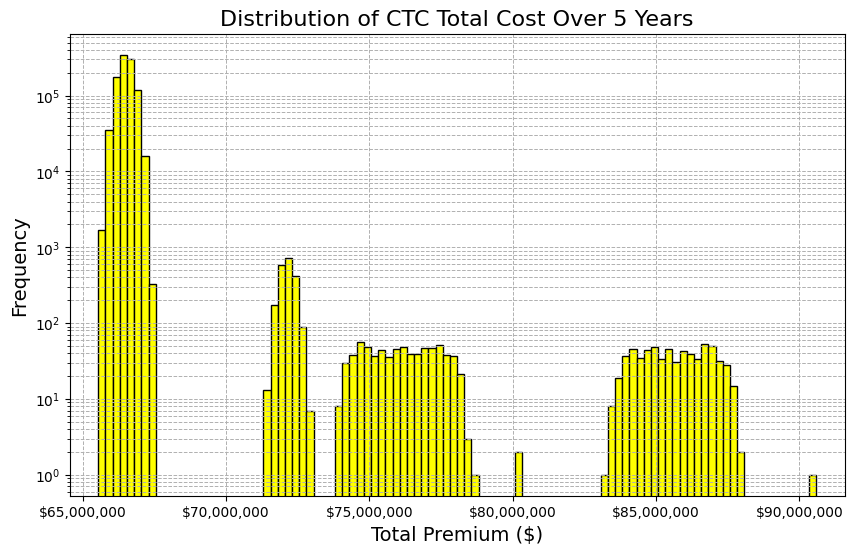

In [71]:
# Calculate the five-year total cost for CTC
five_year_cost_CTC = Final_Cost_CTC.sum(axis=1)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the five-year total premium with more bins and restricted x-axis
plt.hist(five_year_cost_CTC, bins=100, color='yellow', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of CTC Total Cost Over 5 Years', fontsize=16)
plt.xlabel('Total Premium ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([five_year_cost_CTC.min() - 1e6, five_year_cost_CTC.max() + 1e6])

# Optionally, use log scale for the y-axis if necessary to highlight the long tail
ax.set_yscale('log')

# Show the plot
plt.show()

In [72]:
# Calculate the average and standard deviation for the first year
Avg_5yr_cost_CTC = np.mean(five_year_cost_CTC)
STD_5yr_cost_CTC = np.std(five_year_cost_CTC)

# Range
lr_CTC_5yr = np.min(five_year_cost_CTC)
ur_CTC_5yr = np.max(five_year_cost_CTC)

print(f"CTC Average Cost (5 Years): ${Avg_yr1_cost_CTC:,.2f}")
print(f"CTC Standard Deviation (5 Year): ${STD_yr1_cost_CTC:,.2f}")

CTC Average Cost (5 Years): $13,305,942.75
CTC Standard Deviation (5 Year): $298,422.54


# HIC

In [73]:
annual_premium_HIC = TFRC * 0.00165
print(f"{annual_premium_HIC:,.2f}")

total_yearly_cost_HIC = pd.DataFrame(np.where(total_crashes < 24_000_000, total_crashes + annual_premium_HIC, 24_000_000 + annual_premium_HIC))


9,831,195.00


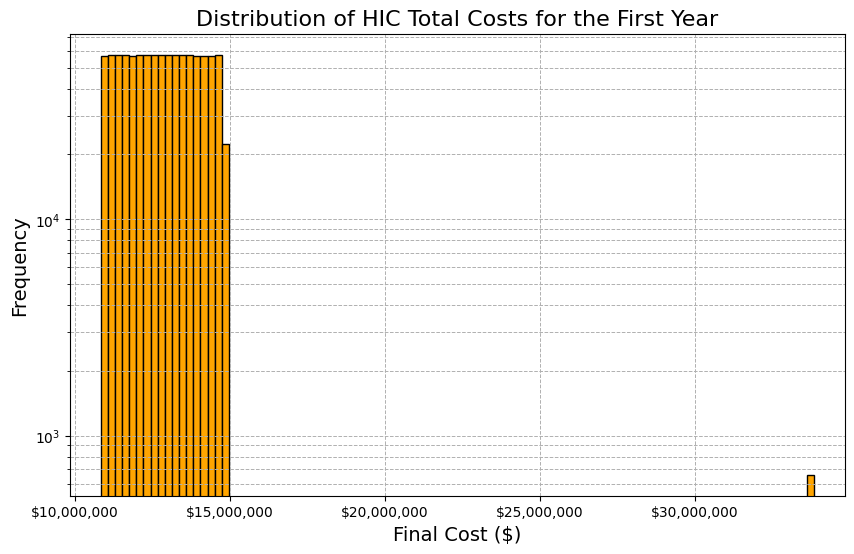

In [74]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the first year's final cost with more bins and restricted x-axis
plt.hist(total_yearly_cost_HIC.iloc[:, 0], bins=100, color='orange', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of HIC Total Costs for the First Year', fontsize=16)
plt.xlabel('Final Cost ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([total_yearly_cost_HIC.iloc[:, 0].min() - 1e6, total_yearly_cost_HIC.iloc[:, 0].max() + 1e6])

# Optionally, use log scale for the y-axis if you want to highlight the long tail
ax.set_yscale('log')

# Show the plot
plt.show()

In [75]:
#Probability of losses exceeding $37mil (10% margin of safety)
HIC_prob_37 = np.mean(total_yearly_cost_HIC.iloc[:, 0] > 37_000_000)

HIC_Avg_yr1_cost = np.mean(total_yearly_cost_HIC.iloc[:, 0])
HIC_STD_yr1_cost = np.std(total_yearly_cost_HIC.iloc[:, 0])

# Range
lr_HIC = np.min(total_yearly_cost_HIC.iloc[:, 0])
ur_HIC = np.max(total_yearly_cost_HIC.iloc[:, 0])

print(f"Probability of losses exceeding $37mil: {HIC_prob_37:.4f}\nAverage Cost: ${HIC_Avg_yr1_cost:,.2f}\nStandard Deviation: ${HIC_STD_yr1_cost:,.2f}")

Probability of losses exceeding $37mil: 0.0000
Average Cost: $12,843,350.38
Standard Deviation: $1,273,241.88


In [76]:
print(f"{annual_premium_HIC:,.2f}")

9,831,195.00


In [77]:
# Calculate rebate
HIC_amt_covered = pd.DataFrame(np.where(total_crashes > 24_000_000, total_crashes-24_000_000, 0))
HIC_rebate = pd.DataFrame(np.where(HIC_amt_covered < annual_premium_HIC, 0.035 * (annual_premium_HIC - HIC_amt_covered),0))

# Sum it over 5 years
HIC_rebate_5yr = HIC_rebate.sum(axis=1)

# Subtract Rebate from 5 year cost totals
HIC_5yr_cost = total_yearly_cost_HIC.sum(axis=1)
HIC_5yr_cost_minus_rebate = HIC_5yr_cost - HIC_rebate_5yr

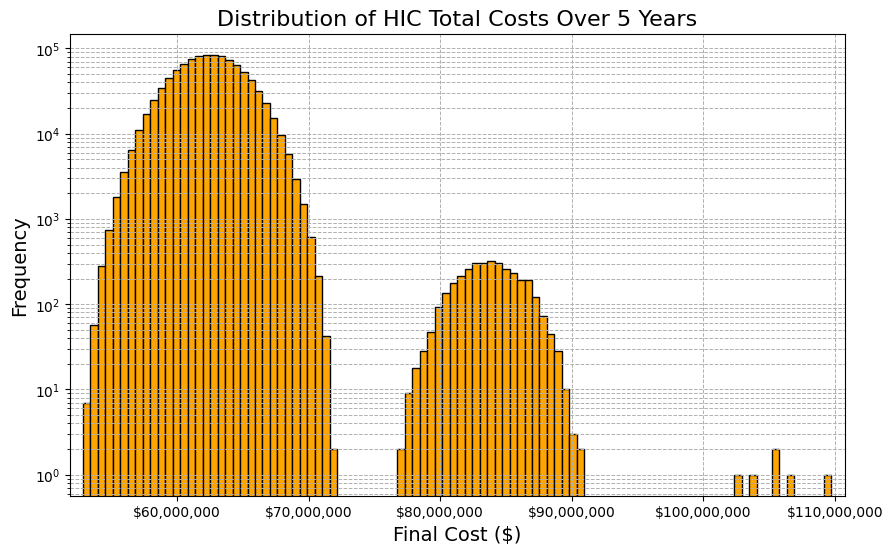

In [78]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram of the first year's final cost with more bins and restricted x-axis
plt.hist(HIC_5yr_cost_minus_rebate, bins=100, color='orange', edgecolor='black')

# Adding a title and labels
plt.title('Distribution of HIC Total Costs Over 5 Years', fontsize=16)
plt.xlabel('Final Cost ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Format the x-axis to avoid scientific notation and limit the x-axis range
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xlim([HIC_5yr_cost_minus_rebate.min() - 1e6, HIC_5yr_cost_minus_rebate.max() + 1e6])

# Optionally, use log scale for the y-axis if you want to highlight the long tail
ax.set_yscale('log')

# Show the plot
plt.show()

In [79]:
HIC_5yr_avg = np.mean(HIC_5yr_cost_minus_rebate)
HIC_5yr_std = np.std(HIC_5yr_cost_minus_rebate)

# Range
lr_HIC_5yr = np.min(HIC_5yr_cost_minus_rebate)
ur_HIC_5yr = np.max(HIC_5yr_cost_minus_rebate)

print(f"HIC Average Cost (5 Years): ${HIC_5yr_avg:,.2f}")
print(f"HIC Standard Deviation (5 Year): ${HIC_5yr_std:,.2f}")

HIC Average Cost (5 Years): $62,506,335.41
HIC Standard Deviation (5 Year): $2,862,304.16


# Summary

We ran a million yearly simulations for 5 years to find what the cost of each insurance plan would be for the next 5 years. Here are the results of our findings:

RCNC1

In [80]:
print(f"First year:\nProbability of losses exceeding $37mil: {prob_37:.4f}\nAverage Cost: ${Avg_yr1_cost:,.2f}\nStandard Deviation: ${STD_yr1_cost:,.2f}\nRange: ${Low_range:,.2f} - ${Upper_range:,.2f}")
print(f"\nFive years:\nAverage Cost: ${Five_Year_Mean:,.2f}\nStandard Deviation: ${Five_Year_STD:,.2f}\nRange: ${Low_range_5yr:,.2f} - ${Upper_range_5yr:,.2f}")


First year:
Probability of losses exceeding $37mil: 0.0000
Average Cost: $22,057,136.86
Standard Deviation: $376,753.15
Range: $21,649,880.17 - $35,662,350.00

Five years:
Average Cost: $110,287,991.95
Standard Deviation: $847,875.26
Range: $108,327,959.16 - $136,477,502.67


RCNC2

In [81]:
print(f"First year:\nProbability of losses exceeding $37mil: {prob_37_RCN2:.4f}\nAverage Cost: ${Avg_yr1_cost_RCN2:,.2f}\nStandard Deviation: ${STD_yr1_cost_RCN2:,.2f}\nRange: ${low_range_RCNC2:,.2f} - ${upper_range_RCNC2:,.2f}")
print(f"\nFive years:\nAverage Cost: ${Five_Year_Mean_RCN2:,.2f}\nStandard Deviation: ${Five_Year_STD_RCN2:,.2f}\nRange: ${lr_5y_RCNC2:,.2f} - ${ur_5y_RCNC2:,.2f}")


First year:
Probability of losses exceeding $37mil: 0.0007
Average Cost: $8,991,612.98
Standard Deviation: $1,787,197.02
Range: $6,958,300.86 - $65,541,300.00

Five years:
Average Cost: $44,969,661.07
Standard Deviation: $4,026,282.44
Range: $35,184,295.81 - $162,573,313.37


CTC

In [82]:
print(f"First year:\nProbability of losses exceeding $37mil: {prob_37_CTC:.4f}\nAverage Cost: ${Avg_yr1_cost_CTC:,.2f}\nStandard Deviation: ${STD_yr1_cost_CTC:,.2f}\nRange: ${lr_CTC:,.2f} - ${ur_CTC:,.2f}")
print(f"\nFive years:\nAverage Cost: ${Avg_5yr_cost_CTC:,.2f}\nStandard Deviation: ${STD_5yr_cost_CTC:,.2f}\nRange: ${lr_CTC_5yr:,.2f} - ${ur_CTC_5yr:,.2f}")


First year:
Probability of losses exceeding $37mil: 0.0000
Average Cost: $13,305,942.75
Standard Deviation: $298,422.54
Range: $13,100,000.09 - $34,471,691.37

Five years:
Average Cost: $66,530,477.59
Standard Deviation: $659,157.97
Range: $65,539,279.58 - $90,582,512.46


HIC

In [83]:
print(f"First year:\nProbability of losses exceeding $37mil: {HIC_prob_37:.4f}\nAverage Cost: ${HIC_Avg_yr1_cost:,.2f}\nStandard Deviation: ${HIC_STD_yr1_cost:,.2f}\nRange: ${lr_HIC:,.2f} - ${ur_HIC:,.2f}")
print(f"\nFive years:\nAverage Cost: ${HIC_5yr_avg:,.2f}\nStandard Deviation: ${HIC_5yr_std:,.2f}\nRange: ${lr_HIC_5yr:,.2f} - ${ur_HIC_5yr:,.2f}")


First year:
Probability of losses exceeding $37mil: 0.0000
Average Cost: $12,843,350.38
Standard Deviation: $1,273,241.88
Range: $10,831,195.86 - $33,831,195.00

Five years:
Average Cost: $62,506,335.41
Standard Deviation: $2,862,304.16
Range: $52,828,311.68 - $109,739,512.89



Recommended insurance plan: 

# RCNC2

It is very unlikely that any of the insurance plans will be cost over $37 million in the first year. The only insurance plan with simulations that did go over the $37 million is RCNC2 but the probability of this occurring was found to be about 0.0007. RCNC2 does, however, have the lowest average cost and smallest lower range of costs for all the insurance plans. While RCNC2's cost does have the highest standard deviation, the sum of it's average cost and standard deviation is still lower than all other insurance plan's average cost.

However, Mary Litton's letter does stipulate that "we must be insured so we do not incur a liability for more than $41 million in aircraft crash losses and insurance costs" for the first year. If RCNC2's probability of going over $37 million is too high for comfort then the next recommended insurance plan would be CTC. CTC and HIC are very similar in terms of average cost with CTC being about half a million dollars more expensive on average but has the benefit of a lower standard deviation and therefore a lower risk of incurring a much greater cost. RCNC1 should not be considered. 